### Домашнее задание 3 - 10 баллов

В этом задании вам предстоит продолжить работу с зачадей машинного перевода из [занятия 7](https://github.com/pacifikus/itmo_dl_nlp_course/blob/main/Lecture%207/itmo_dl_nlp_course_06_seq2seq.ipynb)

Попробуйте улучшить качество модели, проверив следующие гипотезы:

- измените размер словаря / предобработку во время токенизации - **1 балл**
- продолжите эксперименты с различными RNN юнитами в encoder и decoder части: замена GRU/LSTM, изменение количества слоев, использование bidirectional RNN - **1 балл**
- улучшите процесс тренировки: добавьте lr sheduling, early stopping, поэкспериментируйте с оптимизатором - **2 балла**
- поэкспериментируйте с сэмплированием - замените greedy-инференс на альтернативные варианты - **2 балла**
- проведите ablation-study, сделайте выводы о влиянии ваших изменений на итоговую производительность модели - **2 балла**

**Общее**

- Принимаемые решения обоснованы (почему выбрана определенная архитектура/гиперпараметр/оптимизатор/преобразование и т.п.) - **1 балл**
- Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - **1 балл**

**Формат сдачи ДЗ**

- Каждая домашняя работа – PR в отдельную ветку **hw_n**, где **n** - номер домашней работы
- Добавить ментора и pacifikus в reviewers
- Дождаться ревью, если все ок – мержим в main
- Если не ок – вносим исправления и снова отправляем на ревью

In [57]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split
from vocab import Vocab

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from transformers import get_cosine_schedule_with_warmup

%matplotlib inline

# Перед обучением предобработаем данные
В качестве токенайзера будем использовать подход <code>BPE</code>, поскольку его активно используется в GPT-like моделях -- обучается слиянием символов из основного корпуса, выбирая пары по наибольшей частоте встречаемости.
Будем работать с данными, направленными на описание отелей.

In [15]:
# подгружаем данные
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt

# Subword Neural Machine Translation - Unsupervised Word Segmentation for Neural Machine Translation and Text Generation
!pip install subword-nmt -q

--2025-03-19 18:23:18--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18, 2620:100:6026:18::a27d:4612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2025-03-19 18:23:19--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce0d009c50ace4f2a6f5af52328.dl.dropboxusercontent.com/cd/0/inline/CmKp7uwI_1abB0ykPAQ5iTdyTi2J8bDXJwYMdsinFth98GmAsMtCVX-xXlVHPEqUx-iX2uq4R700s-IKOLNZkDAGSrVmHyo6tD-GhmKG5y9fK-UdbHlup82-KhzO5EuBYqA/file?dl=1# [following]
--2025-03-19 18:23:20--  https://uce0d009c50ace4f2a6f5af52328.dl.dropboxusercontent.com/cd/0/inline/CmKp7uwI_1a

In [13]:
with open('data.txt') as f:
  print(f.readlines()[0])

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



In [17]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))

In [18]:
with open('train.en', 'w', encoding='utf-8') as f_src,  open('train.ru', 'w', encoding='utf-8') as f_dst:
  for line in open('data.txt', "r", encoding='utf-8'):
    src_line, dst_line = line.strip().split('\t')
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')


bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang, 'r', encoding='utf-8'), open('bpe_rules.' + lang, 'w', encoding='utf-8'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w', encoding='utf-8') as f_out:
        for line in open('train.' + lang, 'r', encoding='utf-8'):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1417.87it/s]


In [20]:
# Построим словарь

data_inp = np.array(open('./train.bpe.ru', 'r', encoding='utf-8').read().split('\n'))
data_out = np.array(open('./train.bpe.en', 'r', encoding='utf-8').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=2023,
)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .
out: this hotel is located in the centre of paris , 2 minutes from place de la ré@@ pub@@ li@@ que and its metro station , which offers 5 metro lines and 4 bus lines .

inp: на полностью оборудованной мини - кухне можно самостоятельно готовить .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: номера находятся под кры@@ шей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .
out: set under the roof or on the lower floors with bay windows looking out onto the park , they are all equipped with wi - fi access .



In [22]:
###########


import sys
import numpy as np
import torch
import torch.nn.functional as F

class Vocab:
    def __init__(self, tokens, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        """
        A special class that converts lines of tokens into matrices and backwards
        """
        assert all(tok in tokens for tok in (bos, eos, unk))
        self.tokens = tokens
        self.token_to_ix = {t:i for i, t in enumerate(tokens)}
        self.bos, self.eos, self.unk = bos, eos, unk
        self.bos_ix = self.token_to_ix[bos]
        self.eos_ix = self.token_to_ix[eos]
        self.unk_ix = self.token_to_ix[unk]

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        flat_lines = '\n'.join(list(lines)).split()
        tokens = sorted(set(flat_lines))
        tokens = [t for t in tokens if t not in (bos, eos, unk) and len(t)]
        tokens = [bos, eos, unk] + tokens
        return Vocab(tokens, bos, eos, unk)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = [tok if tok in self.token_to_ix else self.unk
                  for tok in string.split()]
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, dtype=torch.int64, max_len=None):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        >>>print(to_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        lines = list(map(self.tokenize, lines))
        max_len = max_len or max(map(len, lines))

        matrix = torch.full((len(lines), max_len), self.eos_ix, dtype=dtype)
        for i, seq in enumerate(lines):
            row_ix = list(map(self.token_to_ix.get, seq))[:max_len]
            matrix[i, :len(row_ix)] = torch.as_tensor(row_ix)

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list,matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = ' '.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines
    
    def compute_mask(self, input_ix):
        """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
        return F.pad(torch.cumsum(input_ix == self.eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

###########

In [23]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1109,   29,    1,    1,    1],
        [   0, 3486, 1869,   29,    1,    1,    1,    1],
        [   0, 2922, 1833, 8034,   59, 3799,   29,    1],
        [   0, 6028, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1869,   29,    1,    1,    1,    1]])

back to words
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']


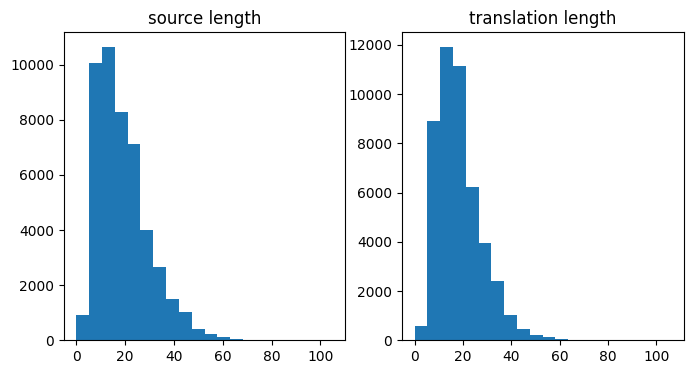

In [24]:
# посмотрим на распределение входных и выходных данных

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

# 2. Строим архитектуру

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # enc_seq: [batch, sequence length, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state) # input & hidden states
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [28]:
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [29]:



train_inp[:3]

array(['этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .',
       'на полностью оборудованной мини - кухне можно самостоятельно готовить .',
       'номера находятся под кры@@ шей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .'],
      dtype='<U524')

In [30]:



dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
price tiles quat@@ thanh chann@@ ski@@ choice villa@@ hvi@@ various sofia villa@@ hvi@@ various sofia villa@@ hvi@@ various sofia villa@@ hvi@@ various sofia villa@@ hvi@@
tiles main@@ ones plan porch enjoyed enjoyed aziz est fu šiben@@ drive ject gorg@@ rostov paddington enti@@ tav@@ tou@@ assisi gäste@@ vale september sville minimalist
tiles main@@ ones plan porch enjoyed enjoyed aziz est fu šiben@@ drive ject gorg@@ rostov paddington enti@@ tav@@ tou@@ assisi gäste@@ vale september sville minimalist


### Loss

Будем минимизировать categorical crossentropy во время обучения на данных $D$:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

$|D|$ - длина всех последовательностей, включая BOS and первые EOS токены, кроме PAD

In [31]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

In [32]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5934, device='cuda:0', grad_fn=<NegBackward0>)


### Оценка качества: BLEU

Распространенная матрика машинного перевода - [BLEU](https://en.wikipedia.org/wiki/BLEU). Эта метрика вычисляет долю верно предсказанных n-grams. В частности, например, для n=1, 2, 3, 4 она вычисляется как геометрическое среднее со штрафом за короткие переводы.

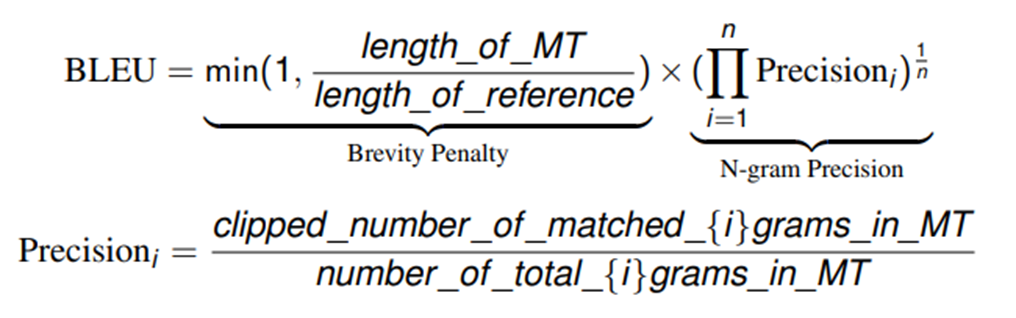

In [33]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [34]:
compute_bleu(model, dev_inp, dev_out)

0.0018175262909859255

# Начинаем обучать

In [35]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

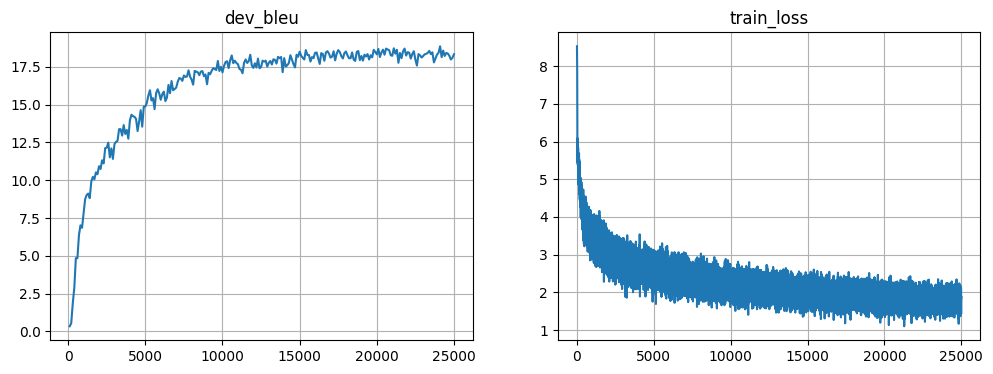

Mean loss=1.763


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [12:39<00:00, 32.93it/s]


In [36]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [37]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [38]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен .
the bathroom is fitted with a bath and a hairdryer .

на территории можно сыграть в дартс и сквош .
other facilities offered at the property include a computer and a volleyball .

апартаменты располагают гостиной зоной .
the apartment will provide you with a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests can prepare their meals in the fully equipped kitchen .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
there is a full kitchen with a dishwasher and a microwave , as well as a private bathroom with a bath or shower and bidet .

ужин для гостей приготовят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er bar .
le of the best western plus stra@@ li@@ ff@@ er has a spacious atmosphere .



In [40]:
compute_bleu(model, dev_inp, dev_out)

18.31933530990192

### Attention

Добавим простой attention:

Имея последовательность $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ из encoder'а и decoder state $h^d$,

* Вычислим логиты двухслойной сеткой
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получим вероятности,
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвесим состояния encoder'а с вероятностями, чтобы получить **attention**
$$ attn = \sum_t p_t \cdot h^e_t $$

[Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/).

In [41]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

### Seq2seq model + attention

Теперь можно использовать слой attention в Seq2Seq модели:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

На каждом шагу используем предыдущее состояние декодера для подсчета attention, затем приконкатенируем attention ко входам следующего слоя. T


In [42]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        #[dec_start] = super().encode(inp, **flags)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]


### Training loop - модель с Attention

In [43]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [44]:
model

AttentiveModel(
  (emb_inp): Embedding(8047, 64)
  (emb_out): Embedding(7800, 64)
  (enc0): LSTM(64, 128, num_layers=2, batch_first=True)
  (dec_start): Linear(in_features=128, out_features=128, bias=True)
  (dec0): GRUCell(192, 128)
  (logits): Linear(in_features=128, out_features=7800, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=128, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [46]:
compute_bleu(model, dev_inp, dev_out)

0.0017981810359666882

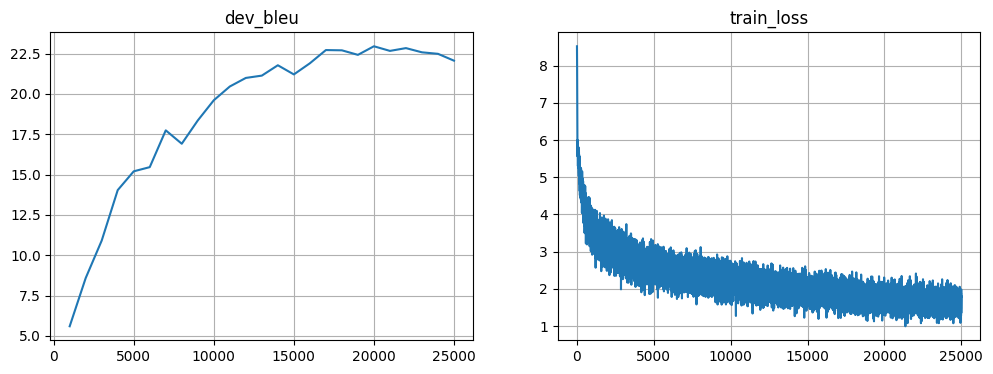

Mean loss=1.703


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [28:28<00:00, 14.64it/s]


In [48]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 1000 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [49]:
compute_bleu(model, dev_inp, dev_out)

22.06135627486482

In [50]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен .
the bathroom comes with a bath and a hairdryer .

на территории можно сыграть в дартс и сквош .
you can play table tennis and play billiards at the property .

апартаменты располагают гостиной зоной .
the apartment will provide you with a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests can prepare meals using the fully equipped kitchen with stove .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
the house has 2 bedrooms and a bathroom with a bath or shower and a kitchen with a dishwasher and a microwave .

ужин для гостей приготовят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er bar .
guests can enjoy a meal at the restaurant at the pacific inn de la bour@@ de l ’ s restaurant .



## Что можно улучшить

* продолжить эксперименты с различными RNN юнитами: gru/lstm; более глубокие архитектуры
* Сделать encoder двунаправленным, попробовать различные attention (additive, dot-product, multi-head, ...)
* улучшить training-процесс: lr sheduling, early stopping и т.п.
* заменить greedy инференс на другие варианты


# Шаги для улучшения
1. Будем использовать модифицированную версию RNN, а именно GRU, поскольку она относительно LSTM будет быстрее обучаться и меньше затрачивать памяти
2. Модель будет двунаправлено обучаться -> bidirectional
3. Добавим early stopping для автоматического контролирования learning rate
4. Будем использовать get_cosine_schedule_with_warmup, который создаст расписание для learning rate
5. Вместо оптимизатора Adam используем AdamW оптимизатор

In [55]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.hid_size = hid_size

        # Encoder (bidirectional)
        self.enc0 = nn.GRU(emb_size, hid_size, num_layers=2, bidirectional=True, batch_first=True)        
        self.dec_start = nn.Linear(hid_size * 2, hid_size)
        
        # Decoder
        self.dec0 = nn.GRUCell(emb_size + hid_size * 2, hid_size) 
        self.attention = AttentionLayer(hid_size * 2, hid_size, attn_size)

    def encode(self, inp, **flags):
        inp_emb = self.emb_inp(inp)
        enc_seq, _ = self.enc0(inp_emb)
        
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1]-1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        
        dec_start = self.dec_start(last_state)
        inp_mask = self.inp_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)
        
        return [dec_start, enc_seq, inp_mask, first_attn_probas]

    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)
        
        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)  # учитываем размер x: [batch, emb_size + hid_size*2]
        new_gru0_state = self.dec0(x, prev_gru0_state)
        
        return [new_gru0_state, enc_seq, enc_mask, attn_probs], self.logits(new_gru0_state)

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, [batch_size]
        :return: (new_state, logits)
        """
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        
        # cчитаем attention
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)
        
        # обновляем состояние
        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        new_gru0_state = self.dec0(x, prev_gru0_state)
        
        new_state = [new_gru0_state, enc_seq, enc_mask, attn_probs]
        return new_state, self.logits(new_gru0_state)

In [58]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
batch_size = 32

# Параметры для early stopping
model_save_path = "best_model.pt"  # Путь для сохранения лучшей модели
limit = 5  # количество попыток после которых нет смысла обучать модель
best_bleu = 0.0
no_improvement_steps = 0

# настраиваем get_cosine_schedule_with_warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer=opt,
    num_warmup_steps=1000, # кол. шагов для фазы разогрева 
    num_training_steps=25000 # кол. шагов для фаза затухания
)

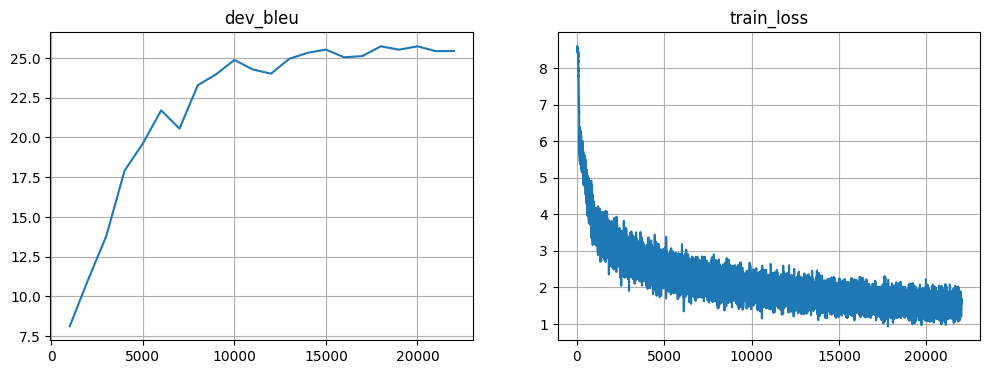

Mean loss=1.561


 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 22001/25000 [25:23<13:50,  3.61it/s]

Current BLEU: 25.440, Best BLEU: 25.737


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 22999/25000 [26:31<02:10, 15.34it/s]/tmp/ipykernel_4031388/3916358607.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue 


Early stopping at step 23000. Best BLEU: 25.737


In [59]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    
    opt.step()
    scheduler.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 1000 == 0:
        current_bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, current_bleu))
        
        # Early stopping логика
        if current_bleu > best_bleu:
            best_bleu = current_bleu
            no_improvement_steps = 0
            
            # Сохраняем лучшую модель
            torch.save(model.state_dict(), model_save_path)
        else:
            no_improvement_steps += 1
            
        # Останавливаем если не было улучшений 5 проверок
        if no_improvement_steps >= limit:
            print(f"\nEarly stopping at step {step}. Best BLEU: {best_bleu:.3f}")
            
            # сохраняем модель с лучшими результатами
            model.load_state_dict(torch.load(model_save_path))
            break
            
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print(f"Mean loss={np.mean(metrics['train_loss'][-10:], axis=0)[1]:.3f}", flush=True)
        print(f"Current BLEU: {current_bleu:.3f}, Best BLEU: {best_bleu:.3f}")

# После цикла (если закончили все шаги без early stopping)
if no_improvement_steps < limit:
    print("Training completed without early stopping")
    print(f"Final Best BLEU: {best_bleu:.3f}")

In [62]:
compute_bleu(model, dev_inp, dev_out)

25.737022052665242

In [70]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен .
the bathroom comes with a bath and hairdryer .

на территории можно сыграть в дартс и сквош .
a games room and are offered .

апартаменты располагают гостиной зоной .
the apartment will provide you with a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests can prepare their meals in the fully equipped kitchen .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
the three - bedroom accommodation features 1 - bedroom and a kitchenette with a bath or shower and a kitchenette with a dishwasher and a microwave .

ужин для гостей приготовят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er bar .
the restaurant guests can visit the cur@@ to@@ aba ’ s garden and the champagne .

